In [1]:
%matplotlib inline

In [2]:
import awkward as ak
import vector
import numpy as np
from hist import Hist
import matplotlib.pyplot as plt
from particle import Particle

In [3]:
mz = Particle.from_string("Z").mass

In [4]:
GeV = 1000

In [5]:
filename = "leptons_100percent.parquet"

In [6]:
array = ak.from_parquet(filename)

In [7]:
len(array)

2979511

In [8]:
def get_leptons(array):
    array["Electrons", "flavor"] = 0
    array["Muons", "flavor"] = 1
    return ak.concatenate([array.Electrons, array.Muons], axis=1)

In [9]:
leptons = get_leptons(array)

In [10]:
leptons = leptons[leptons.p4.pt >= 7 * GeV]

In [11]:
def get_4lep_candidates(leptons):
    comb = ak.combinations(leptons, 4)
    comb = comb[ak.num(comb) > 0]
    return ak.concatenate([c[:, :, np.newaxis] for c in ak.unzip(comb)], axis=2)

In [12]:
candidates = get_4lep_candidates(leptons)

In [13]:
len(candidates)

126085

In [14]:
def filter_sfoc(candidates):
    flavsum = ak.sum(candidates.flavor, axis=2)
    return candidates[
        # total charge 0
        (ak.sum(candidates.charge, axis=2) == 0)
        # total charge 0 for each ee, mumu
        & (ak.sum(candidates[candidates.flavor == 0].charge, axis=2) == 0)
        & (ak.sum(candidates[candidates.flavor == 1].charge, axis=2) == 0)
        # eeee, mumumumu, eemumu
        & (flavsum != 1)
        & (flavsum != 3)
    ]

In [15]:
candidates = filter_sfoc(candidates)

In [16]:
candidates = candidates[ak.num(candidates) != 0]

In [17]:
len(candidates)

85876

In [18]:
def mass(combinations):
    return sum([vector.awk(c) for c in ak.unzip(combinations)[1:]], vector.awk(combinations.slot0)).mass

In [19]:
m4 = mass(ak.zip([candidates.p4[:, :, i] for i in range(4)]))

In [20]:
m4 = ak.flatten(m4)
# alternative: just one candidate per event
# m4 = m4[:, 0]

In [21]:
len(m4)

89561

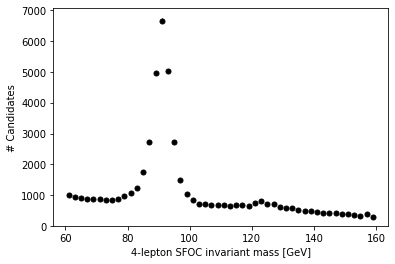

In [22]:
h = Hist.new.Reg(50, 60, 160).Int64()
h.fill(m4 / GeV)
h.plot(histtype="errorbar", color="black")
plt.xlabel("4-lepton SFOC invariant mass [GeV]")
plt.ylabel("# Candidates")
plt.savefig("m4l_wide.pdf")

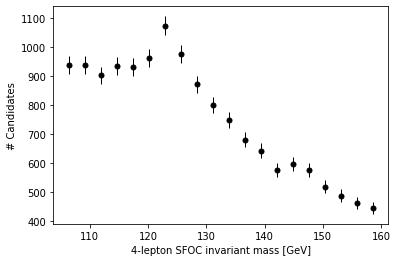

In [23]:
h = Hist.new.Reg(20, 105, 160).Int64()
h.fill(m4 / GeV)
h.plot(histtype="errorbar", color="black")
plt.xlabel("4-lepton SFOC invariant mass [GeV]")
plt.ylabel("# Candidates")
plt.savefig("m4l_zoom.pdf")